In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
np.random.seed(0)

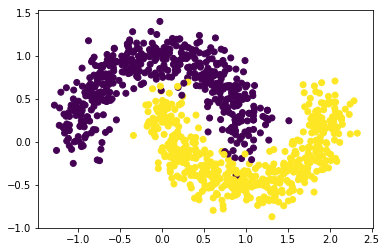

In [2]:
x, y = make_moons(n_samples=1000, noise=0.15)
x = np.column_stack((x, np.multiply(x[:,0], x[:,1])))
y = np.atleast_2d(y).T
x_train, x_test, y_train, y_test = train_test_split(x, y)
plt.scatter(x[:,0], x[:,1], c=y[:,0])

Number of samples, input units, number of output units:

In [3]:
assert x_train.shape[0] == y_train.shape[0]
x_train.shape[0], x_train.shape[1], y_train.shape[1]

(750, 3, 1)

\begin{align*}
h_\Theta(x) &= a^{(j + 1)} \\
a^{(j)} &= g(z^{(j)}) \\
z^{(j)} &= \Theta^{(j - 1)}a^{(j - 1)}
\end{align*}

Where $g$ is an activation function applied element-wise, $a^{(1)} = x$ (the overall network input), and $a^{(j)}_0 = 1$ for a bias unit for all layers $j$.

In [4]:
def sigmoid(z, derivative=False):
    if derivative:
        return z * (1 - z)
    return 1 / (1 + np.exp(-z))


def relu(z, derivative=False):
    if derivative:
        return (z > 0).astype(int)
    return max(0, z)


def softmax(z):
    z_ = np.exp(z)
    return z_ / np.sum(z_, axis=0)

## Vectorized implementation

In [5]:
x_train.shape, y_train.shape

((750, 3), (750, 1))

In [ ]:
def add_bias(m):
    return np.hstack((np.ones((m.shape[0], 1)), m))


def a(weights, layer, activation_func=sigmoid):
    z = layer.dot(weights.T)
    return sigmoid(z)


def construct_weights(layers):
    weights = []
    for l in range(1, len(layers)):
        # Add bias unit.
        incoming_units = layers[l - 1] + 1
        weights.append(np.random.random((layers[l], incoming_units)) - 0.5)
    return tuple(weights)


hidden_1_weights, hidden_2_weights, output_weights = construct_weights([3, 4, 3, 1])
costs = []
accuracies = []
max_learning_rate = 0.0025
min_learning_rate = 0.00001
iterations = 4000
batch_size = 100

costs = []
for i in range(iterations):
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-i/iterations)
    x = add_bias(x_train)
    y = y_train
    hidden_1_output = add_bias(a(hidden_1_weights, x))
    hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
    output_output = a(output_weights, hidden_2_output, activation_func=softmax)
    # x and hidden layer activation outputs all include their bias units.

    # Compute the deltas for each activation and bias unit.
    output_delta = y - output_output
    hidden_2_delta = output_delta.dot(output_weights) * sigmoid(hidden_2_output, derivative=True)
    # We don't connect this layer to the bias unit of the next.
    # For example:
    # - First hidden layer has 4 units and 1 bias unit for a total of 5 units.
    # - Second hidden layer has 3 units and 1 bias unit for a total of 4 units.
    # - The weight matrix between them is (3, 5) because the second hidden layer
    #   uses the first hidden layer's bias but the second hidden layer's bias is
    #   still always just 1.
    # - Thus we can splice off the second hidden layer's bias delta.
    hidden_1_delta = hidden_2_delta[:,1:].dot(hidden_2_weights) * sigmoid(hidden_1_output, derivative=True)

    output_pd = output_delta.T.dot(hidden_2_output)
    output_weights += learning_rate * output_pd

    hidden_2_pd = hidden_2_delta[:,1:].T.dot(hidden_1_output)
    hidden_2_weights += learning_rate * hidden_2_pd

    hidden_1_pd = hidden_1_delta[:,1:].T.dot(x)
    hidden_1_weights += learning_rate * hidden_1_pd

    costs.append(np.average(output_delta ** 2))

    x = add_bias(x_test)
    hidden_1_output = add_bias(a(hidden_1_weights, x))
    hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
    output_output = a(output_weights, hidden_2_output, activation_func=softmax)
    predictions = output_output >= 0.5
    correct = 0
    for p in range(len(predictions)):
        if predictions[p][0] == bool(y_test[p][0]):
            correct += 1
    accuracies.append(correct / len(predictions))

plt.subplot(211)
plt.plot(costs)
plt.subplot(212)
plt.plot(accuracies)
plt.show()
print("cost =", costs[-1], "accuracy =", accuracies[-1])

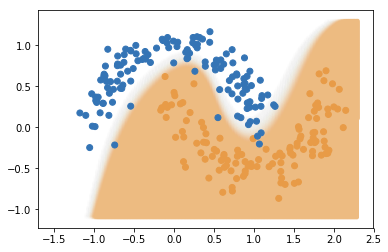

In [7]:
x1_ = np.atleast_2d(np.repeat(np.linspace(-1.5, 2.3, num=400), 100)).T
x2_ = np.atleast_2d(np.tile(np.linspace(-1.1, 1.3, num=200), 200)).T
x3_ = x1_ * x2_
x = add_bias(np.hstack((x1_, x2_, x3_)))
hidden_1_output = add_bias(a(hidden_1_weights, x))
hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
output_output = a(output_weights, hidden_2_output, activation_func=softmax)
cbg = np.hstack((
    np.atleast_2d(np.repeat(237 / 255., len(output_output))).T,
    np.atleast_2d(np.repeat(187 / 255., len(output_output))).T,
    np.atleast_2d(np.repeat(129 / 255., len(output_output))).T,
    output_output
))

def to_c(y):
    a = (232 / 255., 155 / 255., 71 / 255.)
    b = (52 / 255., 116 / 255., 181 / 255.)
    return [ a if y_ == 1 else b for y_ in y ]

plt.scatter(x1_[:,0], x2_[:,0], c=cbg, marker='.')
plt.scatter(x_test[:,0], x_test[:,1], c=to_c(y_test[:,0]))